# Lecture 14 - Bayesian Optimization

```{contents}
:local:
:depth: 1
```

## 1. Learning goals and setup

**Learning goals**

- Explain the ideas behind **Bayesian Optimization** for expensive experiments.
- Define **prior belief**, **surrogate model** (GP, RF, small NN), and **acquisition function** (EI, UCB, PI, greedy).
- Code the BO loop step by step: fit surrogate, compute acquisition, pick next point, update data.
- Compare BO to grid and random search for **hyperparameter tuning**.
- Run a chemistry case study: toy **Suzuki coupling** with three controllable factors (time, temperature, concentration) to optimize yield.

We will keep each code step small, print key shapes, and visualize intermediate structures. Exercises appear after short sections so you can practice by changing something nearby.

---

### 1.1 Imports and global settings

In [1]:
# 1.1 Imports and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Callable, Tuple

# scikit-learn pieces
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)
plt.rcParams["figure.figsize"] = (5.2, 3.6)
plt.rcParams["axes.grid"] = True

We will use **GaussianProcessRegressor** for the GP surrogate, **RandomForestRegressor** for a tree ensemble surrogate, and a small **MLPRegressor** for a neural surrogate. You will see how to read out mean and uncertainty from each.

---

### 1.2 Small helpers for plotting

In [2]:
# 1.2 Small plotting helpers
def parity(y_true, y_pred, title="Parity"):
    plt.scatter(y_true, y_pred, alpha=0.6)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi], "k--", lw=1)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def line_plot_with_ci(x, mean, std, title="", xlabel="x", ylabel="y"):
    idx = np.argsort(x.ravel())
    x_ord = x.ravel()[idx]
    m_ord = mean.ravel()[idx]
    s_ord = std.ravel()[idx]
    plt.plot(x_ord, m_ord, lw=2)
    plt.fill_between(x_ord, m_ord - 1.96*s_ord, m_ord + 1.96*s_ord, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

Each helper is short. We keep them minimal so you can reuse them in exercises.

---

## 2. What is Bayesian Optimization

Bayesian Optimization (BO) is a strategy to optimize an unknown objective $f(x)$ when evaluations are expensive. Think of $f(x)$ as a reaction yield produced by a full experiment. We want to find $x^*$ that maximizes $f(x)$ using as few experiments as possible.

The workflow:

1. **Prior belief** about $f$ (for example a GP prior).
2. **Surrogate model** that maps $x \mapsto$ a predictive **mean** $\mu(x)$ and **uncertainty** $\sigma(x)$.
3. **Acquisition function** $a(x)$ that scores how attractive $x$ is to try next, combining exploration and exploitation.
4. **Update** the dataset with the new measurement and refit the surrogate.

We repeat 2 to 4 until the budget is used.

---

### 2.1 A tiny 1D objective for intuition

We define a 1D function as a stand-in for an expensive lab run. You will not see this function inside the BO loop. The optimizer only sees measured points.

In [3]:
# 2.1 A 1D "hidden" objective (for teaching)
def f_true_1d(x):
    # x shape: (n, 1)
    # multi-peak, smooth, with a small penalty on the right
    x = np.atleast_2d(x)
    s = (
        0.6*np.sin(3.2*x[:,0]) +
        0.9*np.exp(-0.5*(x[:,0]-1.2)**2) -
        0.4*np.exp(-2.0*(x[:,0]+0.8)**2) -
        0.08*x[:,0]
    )
    return s

# Grid for plotting the landscape (which BO will never peek)
x_grid = np.linspace(-2.0, 2.0, 400).reshape(-1, 1)
y_grid = f_true_1d(x_grid)

x_grid[:3].ravel(), y_grid[:3]

(array([-2.        , -1.98997494, -1.97994987]),
 array([0.07299499, 0.09041552, 0.10784925]))

x_grid shape: (400, 1) y_grid shape: (400,)


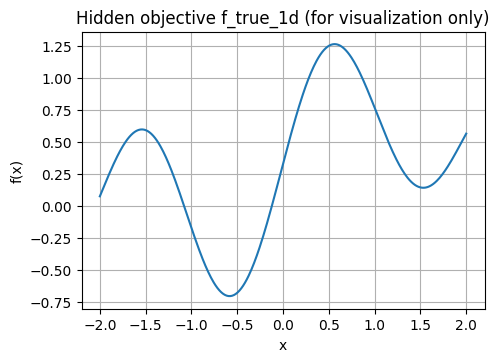

In [4]:
# Inspect the shape and a quick plot to build intuition
print("x_grid shape:", x_grid.shape, "y_grid shape:", y_grid.shape)
plt.plot(x_grid, y_grid)
plt.title("Hidden objective f_true_1d (for visualization only)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

We will now forget the formula and pretend we only get noisy measurements of $f(x)$ at points we choose.

---

```{admonition} Exercise 2.1
Change the function by adding `+ 0.15*np.cos(5.5*x[:,0])` inside `f_true_1d`. Re-run the plot to see how the landscape changes. Which region becomes more attractive?
```

---

## 3. Gaussian Process surrogate: prior, posterior, kernel

A **Gaussian Process (GP)** defines a distribution over functions. You can think of it as a smooth prior belief about how $f$ behaves.

- Prior: $f(x) \sim \mathcal{GP}(m(x), k(x, x'))$ with mean $m(x)$ (often zero) and kernel $k$.
- After observing data $\mathcal{D} = \{(x_i, y_i)\}$, the GP produces a **posterior** with mean $\mu(x)$ and standard deviation $\sigma(x)$ at any new $x$.

Key knob: the **kernel** (RBF, Matern, etc.) and its **length scale** which controls smoothness. We will use RBF and Matern.

---

### 3.1 Draw function samples from the prior

Prior sample matrix shape: (400, 3)


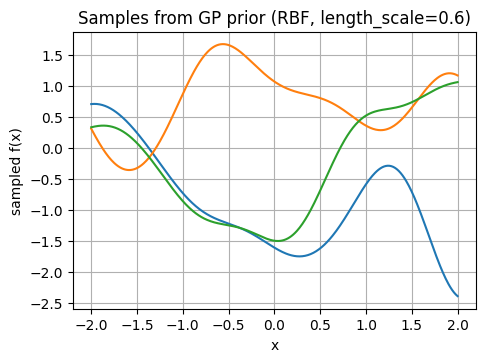

In [5]:
# 3.1 Sample from a GP prior to feel how kernels shape functions
kernel_prior = C(1.0) * RBF(length_scale=0.6)

gpr_prior = GaussianProcessRegressor(kernel=kernel_prior, alpha=1e-8, normalize_y=False)  # not fitted
ys = gpr_prior.sample_y(x_grid, n_samples=3, random_state=1)

print("Prior sample matrix shape:", ys.shape)  # 400 x 3
plt.plot(x_grid, ys)
plt.title("Samples from GP prior (RBF, length_scale=0.6)")
plt.xlabel("x")
plt.ylabel("sampled f(x)")
plt.show()

Longer length scale gives smoother functions.

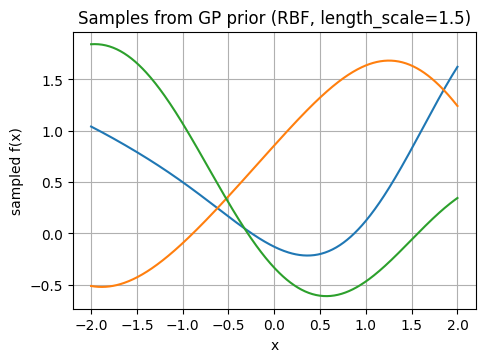

In [6]:
# Try a longer length scale
kernel_prior2 = C(1.0) * RBF(length_scale=1.5)
gpr_prior2 = GaussianProcessRegressor(kernel=kernel_prior2, alpha=1e-8)
ys2 = gpr_prior2.sample_y(x_grid, n_samples=3, random_state=2)

plt.plot(x_grid, ys2)
plt.title("Samples from GP prior (RBF, length_scale=1.5)")
plt.xlabel("x")
plt.ylabel("sampled f(x)")
plt.show()

---

### 3.2 Fit GP posterior on a few points

We start with 3 random points. Measurements are noisy.

In [7]:
# 3.2 Initial data
rng = np.random.RandomState(0)
X_init = rng.uniform(-2.0, 2.0, size=(3, 1))
y_init = f_true_1d(X_init) + rng.normal(0, 0.05, size=(3,))

X_init, y_init

(array([[0.19525402],
        [0.86075747],
        [0.4110535 ]]),
 array([0.71004833, 1.07242262, 1.14352324]))

In [8]:
# Build a GP with a small noise term (WhiteKernel)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.8, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-2)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=3, normalize_y=True, random_state=0)

gp.fit(X_init, y_init)

print("Learned kernel:", gp.kernel_)

Learned kernel: 0.998**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.00389)


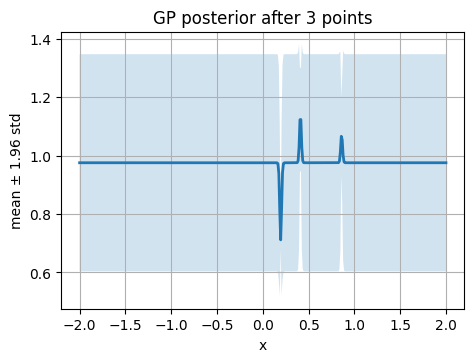

In [9]:
# Predict posterior mean and std on a dense grid
mu, std = gp.predict(x_grid, return_std=True)
line_plot_with_ci(x_grid, mu, std, title="GP posterior after 3 points", xlabel="x", ylabel="mean ± 1.96 std")

We can overlay the current data.

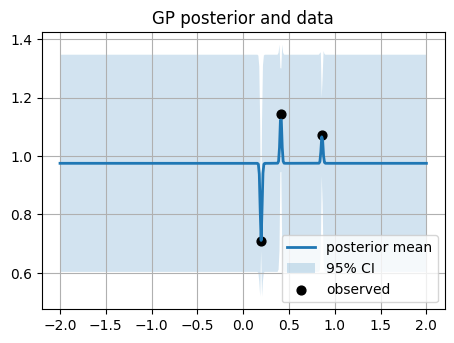

In [10]:
# Overlay data
plt.plot(x_grid, mu, lw=2, label="posterior mean")
plt.fill_between(x_grid.ravel(), mu - 1.96*std, mu + 1.96*std, alpha=0.2, label="95% CI")
plt.scatter(X_init, y_init, c="k", s=40, label="observed")
plt.title("GP posterior and data")
plt.legend()
plt.show()

```{admonition} Exercise 3.2
Change the kernel to `Matern(length_scale=0.8, nu=2.5)` plus `WhiteKernel`. Fit again and compare the uncertainty band. Which kernel seems to capture sharper bumps?
```

---

## 4. Acquisition functions: EI, UCB, PI, greedy

An **acquisition function** $a(x)$ scores how useful a new evaluation at $x$ would be. It uses $\mu(x)$ and $\sigma(x)$ from the surrogate.

We will maximize the acquisition (so higher is better) for **maximization** problems.

Let $y^+$ be the best observed value so far and $\xi \ge 0$ a small margin to encourage exploration.

- **Expected Improvement**  
  $$
  \mathrm{EI}(x) = (\mu(x) - y^+ - \xi)\,\Phi(z) + \sigma(x)\,\phi(z)
  $$
  where $z = \frac{\mu(x) - y^+ - \xi}{\sigma(x)}$, and $\Phi$ and $\phi$ are the CDF and PDF of the standard normal.

- **Upper Confidence Bound**  
  $$
  \mathrm{UCB}(x) = \mu(x) + \kappa\,\sigma(x)
  $$
  where $\kappa > 0$ controls exploration.

- **Probability of Improvement**  
  $$
  \mathrm{PI}(x) = \Phi\!\left(\frac{\mu(x) - y^+ - \xi}{\sigma(x)}\right)
  $$

- **Greedy** (exploitation only)  
  $$
  a(x) = \mu(x)
  $$

---

### 4.1 Implement acquisition functions

We write short functions that accept arrays of $\mu$, $\sigma$, and the current best $y^+$.

In [11]:
# 4.1 Acquisition functions
def acq_ei(mu, sigma, y_best, xi=0.01):
    sigma = np.maximum(sigma, 1e-12)
    z = (mu - y_best - xi) / sigma
    return (mu - y_best - xi) * norm.cdf(z) + sigma * norm.pdf(z)

def acq_ucb(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

def acq_pi(mu, sigma, y_best, xi=0.01):
    sigma = np.maximum(sigma, 1e-12)
    z = (mu - y_best - xi) / sigma
    return norm.cdf(z)

def acq_greedy(mu):
    return mu

In [12]:
# Sanity check: simple arrays
mu_test = np.array([0.1, 0.2, 0.5])
sd_test = np.array([0.05, 0.1, 0.2])
print("EI:", acq_ei(mu_test, sd_test, y_best=0.15))
print("UCB:", acq_ucb(mu_test, sd_test, kappa=1.0))
print("PI:", acq_pi(mu_test, sd_test, y_best=0.15))
print("Greedy:", acq_greedy(mu_test))

EI: [0.00280512 0.06304388 0.34365756]
UCB: [0.15 0.3  0.7 ]
PI: [0.11506967 0.65542174 0.95543454]
Greedy: [0.1 0.2 0.5]


---

### 4.2 Visualize acquisition shapes

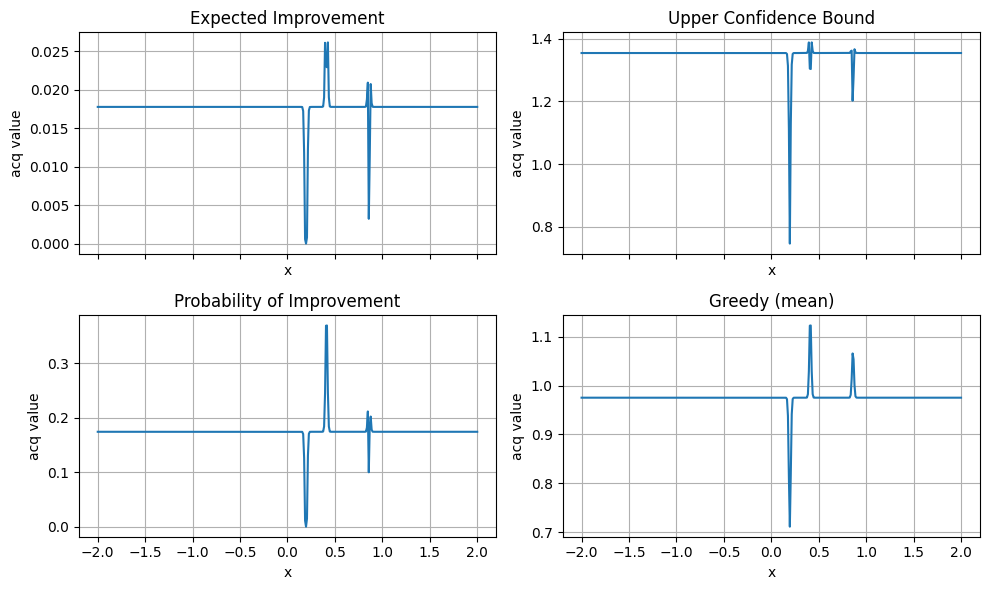

In [13]:
# 4.2 Acquisition profiles over x_grid with current GP
y_best = y_init.max()

mu, std = gp.predict(x_grid, return_std=True)
ei_vals = acq_ei(mu, std, y_best=y_best, xi=0.01)
ucb_vals = acq_ucb(mu, std, kappa=2.0)
pi_vals  = acq_pi(mu, std, y_best=y_best, xi=0.01)
greedy_v = acq_greedy(mu)

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.ravel()

axes[0].plot(x_grid, ei_vals); axes[0].set_title("Expected Improvement")
axes[1].plot(x_grid, ucb_vals); axes[1].set_title("Upper Confidence Bound")
axes[2].plot(x_grid, pi_vals);  axes[2].set_title("Probability of Improvement")
axes[3].plot(x_grid, greedy_v); axes[3].set_title("Greedy (mean)")

for ax in axes:
    ax.set_xlabel("x"); ax.set_ylabel("acq value")
plt.tight_layout()
plt.show()

```{admonition} Tip
- EI and PI look at improvement over the current best.  
- UCB trades off mean and uncertainty with a single knob kappa.  
- Greedy ignores uncertainty and will often get stuck.
```

```{admonition} Exercise 4.2
Increase `kappa` from 2.0 to 4.0 in UCB and replot. What regions rise in score when you increase exploration?
```

---

## 5. The BO loop in 1D step by step

We now implement the loop:

1. Fit surrogate to $(X, y)$.
2. Compute $\mu$, $\sigma$ on a candidate set.  
3. Compute acquisition $a(x)$ and pick $x_{next} = \arg\max a(x)$.
4. Run the experiment (here we call `f_true_1d`) to get $y_{next}$.
5. Append to data and go back to step 1.

We will do 15 iterations and look at the history.

---

### 5.1 Small utility: argmax on a grid

In [14]:
# 5.1 Argmax on a grid
def argmax_on_grid(values, grid):
    idx = np.argmax(values)
    return grid[idx:idx+1], idx

# Quick check
vals = np.array([0.1, 0.3, -0.2, 0.9, 0.4])
grid = np.array([10, 20, 30, 40, 50]).reshape(-1,1)
x_star, idx_star = argmax_on_grid(vals, grid)
x_star, idx_star

(array([[40]]), np.int64(3))

---

### 5.2 Run BO with EI

In [15]:
# 5.2 BO loop with EI
rng = np.random.RandomState(1)

X = X_init.copy()
y = y_init.copy()

# same kernel as before
kernel = C(1.0) * RBF(length_scale=0.8) + WhiteKernel(noise_level=1e-2)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=3, random_state=1)

history_best = [y.max()]

n_iter = 15
for t in range(n_iter):
    gp.fit(X, y)
    mu, std = gp.predict(x_grid, return_std=True)
    acq = acq_ei(mu, std, y_best=y.max(), xi=0.01)
    x_next, idx = argmax_on_grid(acq, x_grid)
    y_next = f_true_1d(x_next) + rng.normal(0, 0.05, size=(1,))
    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])
    history_best.append(y.max())

len(X), len(y), len(history_best)

(18, 18, 16)

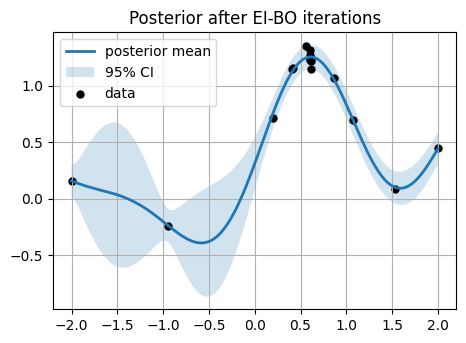

In [16]:
# Plot final posterior and points
gp.fit(X, y)
mu, std = gp.predict(x_grid, return_std=True)

plt.plot(x_grid, mu, lw=2, label="posterior mean")
plt.fill_between(x_grid.ravel(), mu - 1.96*std, mu + 1.96*std, alpha=0.2, label="95% CI")
plt.scatter(X, y, c="k", s=25, label="data")
plt.title("Posterior after EI-BO iterations")
plt.legend()
plt.show()

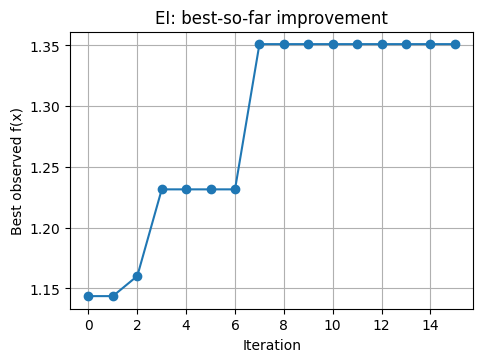

In [17]:
# Track best-so-far vs iteration
plt.plot(history_best, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best observed f(x)")
plt.title("EI: best-so-far improvement")
plt.show()

```{admonition} Exercise 5.2
Replace EI with UCB using `kappa=2.5`. Plot the best-so-far curve again. Which method reached a good point faster on this function?
```

---

### 5.3 Where did BO sample

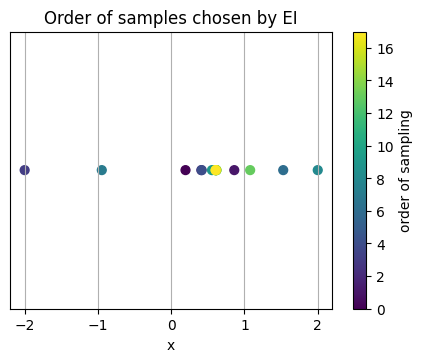

In [18]:
# 5.3 Visualize chosen locations on the x axis
plt.scatter(X.ravel(), np.zeros_like(X.ravel()), c=np.arange(len(X)), cmap="viridis", s=40)
plt.colorbar(label="order of sampling")
plt.yticks([])
plt.xlabel("x")
plt.title("Order of samples chosen by EI")
plt.show()

A healthy pattern often shows some early exploration across the space, then a focus on promising regions.

---

## 6. Surrogate alternatives and simple diagnostics

Gaussian Processes are a common surrogate for low to moderate dimensional spaces. For higher dimensions or larger datasets, tree ensembles and small neural surrogates can help.

We try a **RandomForestRegressor** as a surrogate. Its mean is the average prediction across trees, and an uncertainty proxy is the **standard deviation across trees**.

---

### 6.1 Random Forest surrogate: mean and std from trees

In [19]:
# 6.1 RF surrogate: using tree-wise predictions for mean and std
def rf_mean_std(rf: RandomForestRegressor, Xc: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # collect predictions from each tree
    preds = np.stack([est.predict(Xc) for est in rf.estimators_], axis=1)  # shape (n, n_trees)
    mu = preds.mean(axis=1)
    sd = preds.std(axis=1)
    return mu, sd

# Tiny demo on a few random numbers
rf_demo = RandomForestRegressor(n_estimators=10, random_state=0).fit(x_grid, y_grid)
mu_demo, sd_demo = rf_mean_std(rf_demo, x_grid[:5])
mu_demo[:3], sd_demo[:3]

(array([0.07822115, 0.08693141, 0.11133447]),
 array([0.00798309, 0.00696821, 0.00697044]))

---

### 6.2 BO loop with RF surrogate (UCB)

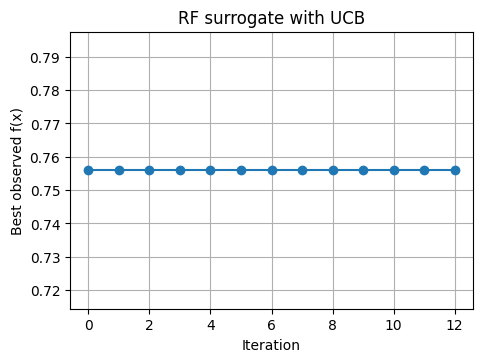

In [20]:
# 6.2 RF-based BO with UCB
rng = np.random.RandomState(2)

X = rng.uniform(-2.0, 2.0, size=(5, 1))
y = f_true_1d(X) + rng.normal(0, 0.05, size=(5,))

history_best_rf = [y.max()]

for t in range(12):
    rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=3, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    mu, sd = rf_mean_std(rf, x_grid)
    acq = acq_ucb(mu, sd, kappa=1.5)  # adjust kappa to see different exploration levels
    x_next, idx = argmax_on_grid(acq, x_grid)
    y_next = f_true_1d(x_next) + rng.normal(0, 0.05, size=(1,))
    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next])
    history_best_rf.append(y.max())

plt.plot(history_best_rf, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best observed f(x)")
plt.title("RF surrogate with UCB")
plt.show()

The RF surrogate can handle more points without much tuning, and the spread across trees gives a simple uncertainty estimate.

```{admonition} Exercise 6.2
Switch to a greedy rule with the RF surrogate by setting `acq = mu` (the mean). Compare best-so-far curves. What changed?
```

---

### 6.3 Small neural surrogate (optional)

A one-hidden-layer MLP can be used as a surrogate but uncertainty is not natural. One way is to train several MLPs with different seeds and use the ensemble standard deviation as a proxy.

In [21]:
# 6.3 Tiny MLP ensemble as surrogate (mean + std across seeds)
def mlp_ensemble_mean_std(X_train, y_train, Xc, n_models=7):
    preds = []
    for seed in range(n_models):
        mdl = MLPRegressor(hidden_layer_sizes=(32,), activation="relu",
                           alpha=1e-3, learning_rate_init=0.01,
                           max_iter=800, random_state=seed)
        mdl.fit(X_train, y_train)
        preds.append(mdl.predict(Xc))
    preds = np.stack(preds, axis=1)  # (n, n_models)
    return preds.mean(axis=1), preds.std(axis=1)

# Quick test on a small slice
mu_e, sd_e = mlp_ensemble_mean_std(x_grid[:100], y_grid[:100], x_grid[:100])
mu_e[:3], sd_e[:3]

(array([0.36277799, 0.36438048, 0.36598297]),
 array([0.09908656, 0.0950063 , 0.09095212]))

This is slower than RF and GP and is here for curiosity. Use only if you have time in class.


---

## 8. Chemistry case study: Suzuki coupling toy dataset

We now switch to a chemistry example that mirrors a common experimental optimization. Consider **Suzuki cross coupling** where you can control:

- Reaction time $t$ in minutes
- Temperature $T$ in Celsius
- Substrate concentration $C$ in molar

Our goal is to **maximize yield**. We will build a toy function that captures a plausible shape: yield grows with time then plateaus, has a sweet spot in temperature, and prefers a moderate concentration. We also add mild interactions and noise.

We generate 800 points to form a dataset you can explore and also use as an oracle to simulate experiments.

---

### 8.1 Create the toy Suzuki dataset

In [22]:
# 8.1 Simulated Suzuki yield function
def suzuki_yield(time_min, temp_c, conc_m, rng=None):
    # time_min in 10..180
    # temp_c in 50..110
    # conc_m in 0.05..1.00
    # returns yield in 0..100
    t = np.array(time_min, dtype=float)
    T = np.array(temp_c, dtype=float)
    C = np.array(conc_m, dtype=float)

    # Time effect: saturating curve
    t0 = 35.0
    time_term = 1.0 - np.exp(-(t - 10.0)/t0)
    time_term = np.clip(time_term, 0, 1.0)

    # Temperature: optimal around ~95 but shifts slightly with concentration
    T_opt = 96.0 - 6.0*(C - 0.35)   # small interaction: higher C prefers slightly lower T
    sigma_T = 9.0
    temp_term = np.exp(-0.5 * ((T - T_opt)/sigma_T)**2)

    # Concentration: moderate optimum
    C_opt = 0.35
    sigma_C = 0.18
    conc_term = np.exp(-0.5 * ((C - C_opt)/sigma_C)**2)

    # Mild over-cooking penalty
    over = np.maximum(t - 140.0, 0)
    burn = np.exp(-0.5 * (over/25.0)**2)

    base = 100.0 * time_term * temp_term * conc_term * (0.85 + 0.15*burn)

    # small nonlinear coupling term
    coupling = 6.0 * np.sin(0.015*(T-70.0)) * np.exp(-3.0*(C - 0.5)**2)

    y = base + coupling

    if rng is not None:
        y = y + rng.normal(0, 1.8, size=np.shape(y))  # lab noise

    return np.clip(y, 0.0, 100.0)

In [23]:
# Generate 800 random experiments
rng = np.random.RandomState(7)
n = 800
time_vals = rng.uniform(10, 180, size=n)
temp_vals = rng.uniform(50, 110, size=n)
conc_vals = rng.uniform(0.05, 1.00, size=n)

yield_vals = suzuki_yield(time_vals, temp_vals, conc_vals, rng=rng)

df_suzuki = pd.DataFrame({
    "time_min": time_vals,
    "temp_c": temp_vals,
    "conc_m": conc_vals,
    "yield": yield_vals
})
df_suzuki.head()

,time_min,temp_c,conc_m,yield
0,22.972409,64.034585,0.345220,0.393040
1,142.586195,53.914309,0.623064,0.000000
2,84.529569,66.327423,0.435255,4.342228
3,132.989080,87.929129,0.897018,5.917039
4,176.258217,104.653480,0.323985,57.983674


In [24]:
# Inspect ranges and a few quantiles
df_suzuki.describe()[["time_min","temp_c","conc_m","yield"]]

,time_min,temp_c,conc_m,yield
count,800.000000,800.000000,800.000000,800.000000
mean,94.616242,79.418759,0.510738,14.535193
std,49.425893,17.436767,0.274654,22.092498
min,10.031436,50.102473,0.051375,0.000000
25%,51.989009,64.015690,0.276434,0.000000
50%,92.955198,80.123321,0.493572,2.801323
75%,138.782055,94.581001,0.740081,22.791306
max,179.954612,109.870879,0.998107,97.916358


---

### 8.2 Visual slices of the surface

We fix one variable and show how yield changes with the other two.

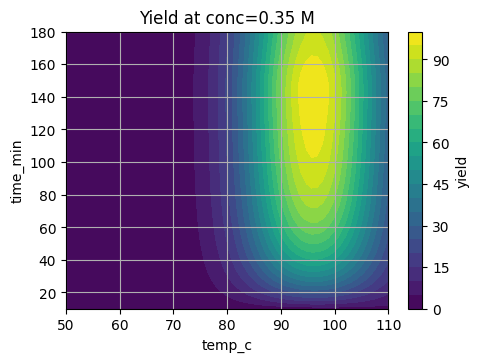

In [25]:
# Fix conc at 0.35 M and scan time, temp
tt = np.linspace(10, 180, 60)
TT = np.linspace(50, 110, 60)
TT_grid, tt_grid = np.meshgrid(TT, tt)
C_fixed = 0.35
YY = suzuki_yield(tt_grid, TT_grid, C_fixed)

plt.contourf(TT_grid, tt_grid, YY, levels=20)
plt.colorbar(label="yield")
plt.xlabel("temp_c")
plt.ylabel("time_min")
plt.title("Yield at conc=0.35 M")
plt.show()

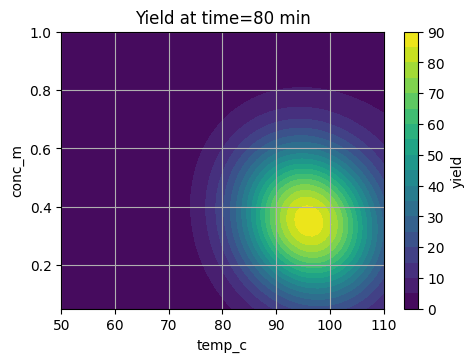

In [26]:
# Fix time at 80 min and scan temp vs conc
cc = np.linspace(0.05, 1.0, 70)
TT = np.linspace(50, 110, 60)
TT_grid, cc_grid = np.meshgrid(TT, cc)
t_fixed = 80.0
YY2 = suzuki_yield(t_fixed, TT_grid, cc_grid)

plt.contourf(TT_grid, cc_grid, YY2, levels=20)
plt.colorbar(label="yield")
plt.xlabel("temp_c")
plt.ylabel("conc_m")
plt.title("Yield at time=80 min")
plt.show()

These slices show a sweet region that we want BO to find in as few trials as possible.

---

### 8.3 Normalize the space to [0,1]^3

GPs like normalized inputs. We scale time, temp, conc to 0..1. We also keep inverse transforms for readability.

In [27]:
# 8.3 Fit a MinMax scaler
scaler_3d = MinMaxScaler().fit(df_suzuki[["time_min","temp_c","conc_m"]])
X_all = scaler_3d.transform(df_suzuki[["time_min","temp_c","conc_m"]].values)
y_all = df_suzuki["yield"].values

X_all[:3], y_all[:3]

(array([[0.07615779, 0.23310162, 0.31037802],
        [0.7800864 , 0.06377678, 0.60385531],
        [0.43842244, 0.27146366, 0.4054797 ]]),
 array([0.39303965, 0.        , 4.34222798]))

In [28]:
# Helpers to decode to lab units
def decode_3d(u):
    return scaler_3d.inverse_transform(u.reshape(1, -1)).ravel()

decode_3d(np.array([0.2, 0.8, 0.3]))

array([44.01607147, 97.91719799,  0.33539433])

---

### 8.4 BO on the Suzuki surface with a GP surrogate

We treat `suzuki_yield` as the lab experiment. At each step, BO proposes a normalized point `u` in [0,1]^3, we decode to lab units, run the experiment, and get a yield.

We use **EI** as the acquisition.

In [29]:
# 8.4 BO loop on 3D Suzuki with GP + EI
rng = np.random.RandomState(10)

# initial 8 random runs
U = rng.rand(8, 3)
lab_pts = np.array([decode_3d(u) for u in U])
y = suzuki_yield(lab_pts[:,0], lab_pts[:,1], lab_pts[:,2], rng=rng)

kernel3 = C(50.0) * Matern(length_scale=[0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(1.0)
gp3 = GaussianProcessRegressor(kernel=kernel3, normalize_y=True, n_restarts_optimizer=3, random_state=0)

best_hist = [y.max()]
trace = [lab_pts[np.argmax(y)]]

In [30]:
# Candidate grid for acquisition (random Latin-style sampling)
def candidate_cloud(m=6000, seed=0):
    rng = np.random.RandomState(seed)
    return rng.rand(m, 3)

U_cand = candidate_cloud(m=6000, seed=1)
U_cand[:3]

array([[4.17022005e-01, 7.20324493e-01, 1.14374817e-04],
       [3.02332573e-01, 1.46755891e-01, 9.23385948e-02],
       [1.86260211e-01, 3.45560727e-01, 3.96767474e-01]])

In [31]:
# BO iterations
n_iter = 30
for t in range(n_iter):
    gp3.fit(U, y)
    mu, sd = gp3.predict(U_cand, return_std=True)
    ei = acq_ei(mu, sd, y_best=y.max(), xi=0.01)
    u_next, idx = argmax_on_grid(ei, U_cand)
    lab_next = decode_3d(u_next.ravel())
    y_next = suzuki_yield(lab_next[0], lab_next[1], lab_next[2], rng=rng)

    U = np.vstack([U, u_next])
    y = np.hstack([y, y_next])
    best_hist.append(y.max())
    if y_next == y.max():
        trace.append(lab_next)

len(U), len(y), len(best_hist), len(trace)

(38, 38, 31, 12)

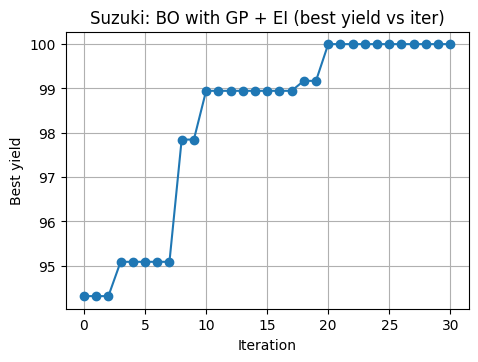

In [32]:
# Plot improvement
plt.plot(best_hist, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best yield")
plt.title("Suzuki: BO with GP + EI (best yield vs iter)")
plt.show()

In [33]:
cols = ["time_min","temp_c","conc_m"]
df_last = pd.DataFrame([decode_3d(u) for u in U[-10:]], columns=cols)

# Option 1: assign via **dict (works with keyword collisions)
df_last = df_last.assign(**{"yield": y[-10:]})

# Option 2: set the column directly
# df_last["yield"] = y[-10:]

df_last

,time_min,temp_c,conc_m,yield
0,139.647778,95.855006,0.343132,100.000000
1,139.647778,95.855006,0.343132,99.288451
2,167.332810,96.793277,0.342383,93.942525
3,139.647778,95.855006,0.343132,100.000000
4,139.647778,95.855006,0.343132,98.582025
5,139.647778,95.855006,0.343132,100.000000
6,139.647778,95.855006,0.343132,100.000000
7,139.647778,95.855006,0.343132,99.920253
8,139.647778,95.855006,0.343132,100.000000
9,139.647778,95.855006,0.343132,100.000000


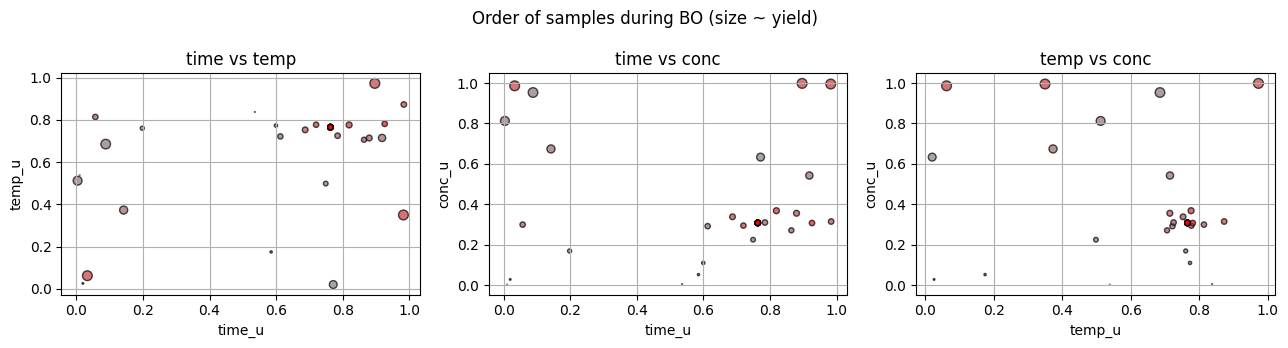

In [34]:
from matplotlib.colors import LinearSegmentedColormap

# custom colormap from grey to red
grey_red = LinearSegmentedColormap.from_list("grey_red", ["grey", "red"])

orders = np.arange(len(U))
Y = U[:, -1]   
size_scale = 50  # adjust scaling factor to taste

fig, axes = plt.subplots(1, 3, figsize=(13,3.5))

axes[0].scatter(U[:,0], U[:,1], c=orders, cmap=grey_red, s=Y*size_scale, alpha=0.7, edgecolor="k")
axes[0].set_xlabel("time_u"); axes[0].set_ylabel("temp_u"); axes[0].set_title("time vs temp")

axes[1].scatter(U[:,0], U[:,2], c=orders, cmap=grey_red, s=Y*size_scale, alpha=0.7, edgecolor="k")
axes[1].set_xlabel("time_u"); axes[1].set_ylabel("conc_u"); axes[1].set_title("time vs conc")

axes[2].scatter(U[:,1], U[:,2], c=orders, cmap=grey_red, s=Y*size_scale, alpha=0.7, edgecolor="k")
axes[2].set_xlabel("temp_u"); axes[2].set_ylabel("conc_u"); axes[2].set_title("temp vs conc")

plt.suptitle("Order of samples during BO (size ~ yield)")
plt.tight_layout()
plt.show()

---

### 8.5 Compare to grid and random for the same number of lab runs

In [35]:
# Build a small grid across each axis (5 x 5 x 5 = 125)
g = np.linspace(0, 1, 5)
G = np.stack(np.meshgrid(g, g, g), axis=-1).reshape(-1,3)

def run_strategy(U_points):
    ys = []
    for u in U_points:
        t, T, C = decode_3d(u)
        ys.append(suzuki_yield(t, T, C, rng=np.random.RandomState(0)))
    return np.max(ys)

budget = len(U)  # how many points BO used
best_grid = run_strategy(G[:budget])
best_rand = run_strategy(np.random.RandomState(123).rand(budget, 3))
best_bo = y.max()

pd.DataFrame({
    "Method": ["BO (EI)", "Grid", "Random"],
    "Best yield": [best_bo, best_grid, best_rand]
})

,Method,Best yield
0,BO (EI),100.000000
1,Grid,2.986924
2,Random,84.515504


```{admonition} Exercise 8.5
Change the BO acquisition to UCB with `kappa=2.2` and re-run Section 8.4 through 8.5. Do you see more exploration early on? How does the final best yield compare?
```

---

### 8.6 A quick RF surrogate on Suzuki

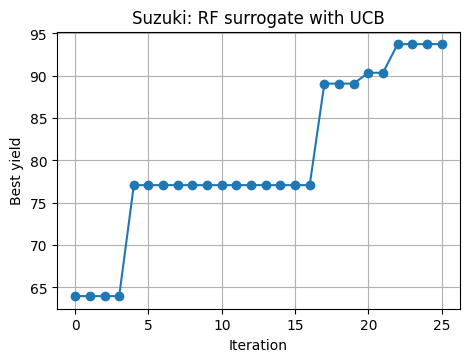

In [36]:
# 8.6 Repeat BO with RF + UCB on Suzuki
rng = np.random.RandomState(11)
U_rf = rng.rand(10, 3)
lab_rf = np.array([decode_3d(u) for u in U_rf])
y_rf = suzuki_yield(lab_rf[:,0], lab_rf[:,1], lab_rf[:,2], rng=rng)

best_hist_rf = [y_rf.max()]

for t in range(25):
    rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, random_state=0, n_jobs=-1)
    rf.fit(U_rf, y_rf)
    mu, sd = rf_mean_std(rf, U_cand)
    acq = acq_ucb(mu, sd, kappa=1.6)
    u_next, idx = argmax_on_grid(acq, U_cand)
    lab_next = decode_3d(u_next.ravel())
    y_next = suzuki_yield(lab_next[0], lab_next[1], lab_next[2], rng=rng)

    U_rf = np.vstack([U_rf, u_next])
    y_rf = np.hstack([y_rf, y_next])
    best_hist_rf.append(y_rf.max())

plt.plot(best_hist_rf, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best yield")
plt.title("Suzuki: RF surrogate with UCB")
plt.show()

```{admonition} Exercise 8.6
Reduce the number of trees to 100. Does the curve become noisier or slower to improve?
```

---

## 9. Glossary

```{glossary}
Bayesian Optimization
  A method to optimize expensive black-box functions by fitting a surrogate with uncertainty and choosing the next experiment via an acquisition function.

Surrogate model
  A fast predictive model (GP, random forest, small NN) that provides a mean $\mu(x)$ and an uncertainty proxy $\sigma(x)$.

Prior belief
  Initial assumption about the shape of the objective before data, such as a GP with a chosen kernel.

Posterior
  Updated belief after seeing data. For a GP this yields closed-form $\mu(x)$ and $\sigma(x)$.

Kernel (covariance function)
  Function defining similarity between inputs. Common choices: RBF, Matern. The length scale sets smoothness.

Expected Improvement (EI)
  Acquisition that scores the expected gain over the current best.

Upper Confidence Bound (UCB)
  Acquisition that adds a multiple of uncertainty to the mean: $\mu + \kappa \sigma$.

Probability of Improvement (PI)
  Acquisition that scores the probability to improve over the best by at least a margin.

Exploration
  Trying uncertain regions with high $\sigma(x)$ to gain information.

Exploitation
  Focusing near known good regions with high $\mu(x)$.
```